<a href="https://colab.research.google.com/github/vectara/example-notebooks/blob/main/notebooks/api-examples/6-artifacts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vectara Artifacts: Working with Files in Agent Sessions

This notebook demonstrates how to use Vectara's **Artifacts** feature to work with files in agent sessions. Artifacts enable agents to access and process files without storing them permanently in a corpus.

You'll learn how to:
1. Upload files (PDFs, images, documents) to an agent session
2. List artifacts in a session
3. Retrieve artifact details and content
4. Create agents with artifact-processing tools
5. Have agents analyze uploaded files and generate new artifacts

## What Are Artifacts?

In Vectara, Artifacts are **session-specific file storage** that enable agents to work with files on-the-fly:

- **Temporary Storage**: Files persist within a session without permanent indexing
- **Multi-Modal Support**: Handle PDFs, DOCX, PPTX, and images (PNG, JPEG, GIF, WebP)
- **Session Scope**: Artifacts remain attached to their specific session
- **Two-Way Flow**: Users can upload files, and agents can generate new artifacts

## Getting Started

This notebook assumes you've completed Notebooks 1-5:
- Notebook 1: Created corpora
- Notebook 2: Ingested data
- Notebook 3: Queried data
- Notebook 4: Created agents and sessions
- Notebook 5: Built multi-agent workflows with sub-agents

Now we'll extend agent capabilities by working with file artifacts.

## Setup

In [1]:
# No additional dependencies required beyond requests

In [2]:
import os
import json
import base64
from datetime import datetime

import requests

# Get credentials from environment variables
api_key = os.environ['VECTARA_API_KEY']

# Base API URL
BASE_URL = "https://api.vectara.io/v2"

# Common headers (for JSON requests)
headers = {
    "x-api-key": api_key,
    "Content-Type": "application/json"
}

# Headers for multipart uploads (no Content-Type - requests sets it automatically)
upload_headers = {
    "x-api-key": api_key
}

## Step 1: Create an Agent with Artifact Tools

To work with artifacts, agents need specific tool configurations. The key artifact-related tools are:

- **`artifact_read`**: Read text content from files (PDF, DOCX, TXT)
- **`image_read`**: Analyze visual files (PNG, JPEG)
- **`document_conversion`**: Convert between formats (e.g., PDF to markdown)
- **`artifact_grep`**: Search for patterns within artifact content
- **`artifact_create`**: Generate new artifacts (reports, summaries, code)

Let's create an agent configured to work with artifacts:

In [3]:
# Helper function to delete and create agent
def delete_and_create_agent(agent_config, agent_name):
    """Delete agent if it exists, then create a new one."""
    list_response = requests.get(f"{BASE_URL}/agents", headers=headers)

    if list_response.status_code == 200:
        agents = list_response.json().get('agents', [])
        for agent in agents:
            if agent.get('name') == agent_name:
                existing_key = agent['key']
                print(f"Deleting existing agent '{agent_name}' ({existing_key})")
                delete_response = requests.delete(f"{BASE_URL}/agents/{existing_key}", headers=headers)
                if delete_response.status_code == 204:
                    print(f"Deleted agent: {existing_key}")
                break

    response = requests.post(f"{BASE_URL}/agents", headers=headers, json=agent_config)

    if response.status_code == 201:
        agent_data = response.json()
        print(f"Created agent '{agent_name}'")
        print(f"Agent Key: {agent_data['key']}")
        return agent_data['key']
    else:
        print(f"Error creating agent: {response.status_code}")
        print(f"{response.text}")
        return None

In [4]:
# Create an agent with artifact processing capabilities
artifact_agent_config = {
    "name": "Document Analyst",
    "description": "Agent that analyzes uploaded documents and images, and can generate reports",
    "model": {"name": "gpt-4o"},
    "first_step": {
        "type": "conversational",
        "instructions": [
            {
                "type": "inline",
                "name": "artifact_instructions",
                "template": """
You are a document analysis assistant that helps users understand and process their files.
Always be thorough in your analysis and cite specific sections of documents when relevant."""
            }
        ],
        "output_parser": {"type": "default"}
    },
    "tool_configurations": {
        "artifact_read": {
            "type": "artifact_read"
        },
        "image_read": {
            "type": "image_read"
        },
        "document_conversion": {
            "type": "document_conversion"
        },
        "artifact_grep": {
            "type": "artifact_grep"
        }
        # Note: artifact_create is a built-in tool that doesn't need explicit configuration
    }
}

artifact_agent_key = delete_and_create_agent(artifact_agent_config, "Document Analyst")

if not artifact_agent_key:
    print("\n⚠️  Agent creation failed. Please check the error above.")
    print("    Subsequent cells will not work without a valid agent.")

Created agent 'Document Analyst'
Agent Key: agt_document_analyst_11ef


## Step 2: Create a Session for Working with Artifacts

Artifacts are session-scoped, so we need to create a session first:

In [5]:
session_key = None
session_name = f"Artifact Demo {datetime.now().strftime('%Y%m%d-%H%M%S')}"
session_config = {
    "name": session_name,
    "metadata": {
        "purpose": "artifact_demo"
    }
}

response = requests.post(
    f"{BASE_URL}/agents/{artifact_agent_key}/sessions",
    headers=headers,
    json=session_config
)

if response.status_code == 201:
    session_data = response.json()
    session_key = session_data["key"]
    print(f"✓ Session Created: {session_key}")
    print(f"  Session Name: {session_name}")
else:
    print(f"Error creating session: {response.status_code}")
    print(response.text)

✓ Session Created: ase_artifact_demo_20251216-103059_8d36
  Session Name: Artifact Demo 20251216-103059


## Step 3: Upload an Artifact

Upload files to a session using multipart form data via the **events** endpoint:

```
POST /v2/agents/{agent_key}/sessions/{session_key}/events
```

The upload creates an `ArtifactUploadEvent` that stores the file in the session's workspace.

Let's create a sample text file and upload it:

In [6]:
# Create a sample document to upload
sample_document = """# Quarterly Sales Report - Q3 2024

## Executive Summary
Q3 2024 showed strong growth across all product lines with total revenue of $4.2M,
representing a 23% increase over Q2 2024.

## Key Metrics
- Total Revenue: $4,200,000
- New Customers: 127
- Customer Retention Rate: 94%
- Average Deal Size: $33,071

## Product Performance
1. Enterprise Suite: $2.1M (50% of revenue)
2. Professional Plan: $1.3M (31% of revenue)
3. Starter Plan: $800K (19% of revenue)

## Regional Breakdown
- North America: 45% ($1.89M)
- Europe: 30% ($1.26M)
- Asia Pacific: 25% ($1.05M)

## Q4 Outlook
Based on current pipeline, we project Q4 revenue of $4.8-5.2M.
Key initiatives include:
- Launch of new AI features
- Expansion into Latin American markets
- Enterprise customer success program
"""

# Save to a temporary file
temp_file_path = "/tmp/q3_sales_report.md"
with open(temp_file_path, "w") as f:
    f.write(sample_document)

print(f"Created sample document: {temp_file_path}")
print(f"Document size: {len(sample_document)} characters")

Created sample document: /tmp/q3_sales_report.md
Document size: 774 characters


In [7]:
# Upload the file as an artifact via the events endpoint
artifact_id = None

upload_url = f"{BASE_URL}/agents/{artifact_agent_key}/sessions/{session_key}/events"
with open(temp_file_path, "rb") as f:
    file_content = f.read()

# Upload file without message using standard requests
files = {"files": ("q3_sales_report.md", file_content, "text/markdown")}
data = {"stream_response": "false"}

upload_response = requests.post(upload_url, headers=upload_headers, files=files, data=data)

if upload_response.status_code in [200, 201]:
    event_data = upload_response.json()
    print("✓ Artifact uploaded successfully!")
    print(json.dumps(event_data, indent=2))

    # Extract artifact_id from the response
    events = event_data.get("events", [])
    for event in events:
        if event.get("type") == "artifact_upload":
            artifacts = event.get("artifacts", [])
            for artifact in artifacts:
                artifact_id = artifact.get("artifact_id")
                print(f"\nArtifact ID: {artifact_id}")
                break
else:
    print(f"Error uploading artifact: {upload_response.status_code}")
    print(upload_response.text)

✓ Artifact uploaded successfully!
{
  "events": [
    {
      "id": "aev_56ea2077-6580-4040-a147-9a4ea391768f",
      "session_key": "ase_artifact_demo_20251216-103059_8d36",
      "type": "artifact_upload",
      "artifacts": [
        {
          "artifact_id": "art_q3_sales_report_md_0_5561801691450937_0003",
          "filename": "q3_sales_report.md",
          "mime_type": "text/markdown",
          "size_bytes": 774
        }
      ],
      "created_at": "2025-12-16T18:31:00.279Z"
    },
    {
      "id": "aev_607d1cc9-3299-4928-8ca2-731263f35e9d",
      "session_key": "ase_artifact_demo_20251216-103059_8d36",
      "type": "tool_input",
      "tool_call_id": "call_BqWCgc7ItXwKJCnReMpXBebW",
      "tool_configuration_name": "artifact_read",
      "tool_name": "vectara_artifact_read",
      "tool_input": {
        "artifact_id": "art_q3_sales_report_md_0_5561801691450937_0003",
        "encoding": "raw"
      },
      "created_at": "2025-12-16T18:31:01.205Z"
    },
    {
      "id

## Step 4: List Artifacts in a Session

Retrieve all artifacts currently stored in a session:

```
GET /v2/agents/{agent_key}/sessions/{session_key}/artifacts
```

In [8]:
# List all artifacts in the session
if not artifact_agent_key or not session_key:
    print("⚠️  Agent or session not available. Run previous cells first.")
else:
    list_url = f"{BASE_URL}/agents/{artifact_agent_key}/sessions/{session_key}/artifacts"
    response = requests.get(list_url, headers=headers)

    if response.status_code == 200:
        artifacts = response.json()
        print("Artifacts in session:")
        print(json.dumps(artifacts, indent=2))
    else:
        print(f"Error listing artifacts: {response.status_code}")
        print(response.text)

Artifacts in session:
{
  "artifacts": [
    {
      "artifact_id": "art_q3_sales_report_md_0_5561801691450937_0003",
      "filename": "q3_sales_report.md",
      "mime_type": "text/markdown",
      "size_bytes": 774,
      "checksum_sha256": "494160d6b4786550a93eac5cf1e327b4bc0b1c79344b23037a432821c6a5bf37",
      "metadata": {
        "original_filename": "q3_sales_report.md"
      },
      "ttl_days": 30,
      "created_at": "2025-12-16T18:31:00.152Z"
    }
  ],
  "metadata": {
    "page_key": "AKm-xomS862oliRXEBWcRknDJCOTUMPG3DOFMoxEvcDpNuHxDD82PQlbIrYCvZA7jCf27Xc110_TZIUjB0hlmPHHNz1Xw0zCwwQ4hqH_xzJXKy-qf38g28LViSH8_BBxN34cKOlDTpqCnOsDCdSFvDv6g_aMw3CGDa0oFg=="
  }
}


## Step 5: Chat with Agent to Analyze the Artifact

Now let's ask the agent to analyze our uploaded document:

In [9]:
# Helper function to chat with the agent
def chat_with_agent(agent_key, session_key, message, show_events=False):
    """Send a message to an agent and return the response."""
    message_data = {
        "messages": [
            {
                "type": "text",
                "content": message
            }
        ],
        "stream_response": False
    }
    
    url = f"{BASE_URL}/agents/{agent_key}/sessions/{session_key}/events"
    response = requests.post(url, headers=headers, json=message_data)
    
    if response.status_code == 201:
        event_data = response.json()
        
        if show_events:
            print("\n------ Agent Events ------")
            for event in event_data.get('events', []):
                event_type = event.get('type', 'unknown')
                print(f"Event: {event_type}")
                if event_type == 'tool_input':
                    tool_name = event.get('tool_configuration_name', 'N/A')
                    print(f"  Tool: {tool_name}")
                if event_type == 'tool_output':
                    tool_name = event.get('tool_configuration_name', 'N/A')
                    print(f"  Tool: {tool_name}")
            print("-" * 25 + "\n")
        
        # Extract agent output
        for event in event_data.get('events', []):
            if event.get('type') == 'agent_output':
                return event.get('content', 'No content')
        
        return "No agent output found"
    else:
        return f"Error: {response.status_code} - {response.text}"

In [10]:
# Ask the agent to analyze the uploaded document
query = "I've uploaded a Q3 sales report. Can you analyze it and tell me the key insights?"
print(f"User: {query}")
print("\n" + "="*80 + "\n")

response = chat_with_agent(
    artifact_agent_key,
    session_key,
    query,
    show_events=True
)

print(f"Agent Response:\n\n{response}")

User: I've uploaded a Q3 sales report. Can you analyze it and tell me the key insights?



------ Agent Events ------
Event: input_message
Event: agent_output
-------------------------

Agent Response:

Based on the "Quarterly Sales Report - Q3 2024," here are the key insights:

1. **Strong Revenue Growth**: The total revenue for Q3 2024 was $4.2 million, indicating a 23% increase compared to Q2 2024. This growth suggests a robust performance across various product lines.

2. **Key Metrics**:
   - The company acquired 127 new customers.
   - The customer retention rate was notable at 94%, reflecting strong customer satisfaction and loyalty.
   - The average deal size was $33,071, which can help assess the company's growth in terms of customer value.

3. **Product Performance**:
   - The Enterprise Suite was the top performer, contributing $2.1 million, or 50% of the total revenue.
   - The Professional Plan followed with $1.3 million, representing 31% of the revenue.
   - The Starter P

## Step 6: Ask the Agent to Create a New Artifact

Agents can generate new artifacts based on their analysis. Let's ask for an executive summary:

In [11]:
# Ask the agent to create a summary artifact
query = "Based on the sales report, please create a one-page executive brief that I can share with the board. Save it as an artifact."
print(f"User: {query}")
print("\n" + "="*80 + "\n")

response = chat_with_agent(
    artifact_agent_key,
    session_key,
    query,
    show_events=True
)

print(f"Agent Response:\n\n{response}")

User: Based on the sales report, please create a one-page executive brief that I can share with the board. Save it as an artifact.



------ Agent Events ------
Event: input_message
Event: tool_input
  Tool: document_conversion
Event: tool_output
  Tool: document_conversion
Event: tool_input
  Tool: artifact_read
Event: tool_output
  Tool: artifact_read
Event: agent_output
-------------------------

Agent Response:

Here is a concise executive brief based on the Q3 2024 sales report:

---

**Quarterly Sales Report - Q3 2024**

**Executive Summary:**
- Q3 2024 showcased robust growth across all product lines with total revenue of $4.2 million, marking a 23% increase from Q2 2024.

**Key Metrics:**
- **Total Revenue:** $4,200,000
- **New Customers:** 127
- **Customer Retention Rate:** 94%
- **Average Deal Size:** $33,071

**Product Performance:**
1. **Enterprise Suite:** $2.1M (50% of total revenue)
2. **Professional Plan:** $1.3M (31% of total revenue)
3. **Starter Plan:** $800K (19% of

In [12]:
# List artifacts again to see the new one created by the agent
list_url = f"{BASE_URL}/agents/{artifact_agent_key}/sessions/{session_key}/artifacts"
response = requests.get(list_url, headers=headers)

if response.status_code == 200:
    artifacts = response.json()
    print("All artifacts in session (including agent-generated):")
    print(json.dumps(artifacts, indent=2))
else:
    print(f"Error: {response.status_code}")
    print(response.text)

All artifacts in session (including agent-generated):
{
  "artifacts": [
    {
      "artifact_id": "art_q3_sales_report_md_0_5561801691450937_0003",
      "filename": "q3_sales_report.md",
      "mime_type": "text/markdown",
      "size_bytes": 774,
      "checksum_sha256": "494160d6b4786550a93eac5cf1e327b4bc0b1c79344b23037a432821c6a5bf37",
      "metadata": {
        "original_filename": "q3_sales_report.md"
      },
      "ttl_days": 30,
      "created_at": "2025-12-16T18:31:00.152Z"
    },
    {
      "artifact_id": "art_d00f86812daf49929886",
      "filename": "q3_sales_report.md.md",
      "mime_type": "text/markdown",
      "size_bytes": 834,
      "checksum_sha256": "1f983cd2510d7dc23e5eaa9c0a62b453ce00115b60f4e7e67361757f417be631",
      "metadata": {
        "original_format": "text/markdown",
        "output_format": "markdown",
        "original_artifact_id": "art_q3_sales_report_md_0_5561801691450937_0003"
      },
      "ttl_days": 30,
      "created_at": "2025-12-16T18:3

## Step 7: Working with Images

Artifacts also support image analysis. Let's create and upload a simple image for the agent to analyze:

Created chart: /tmp/revenue_chart.png


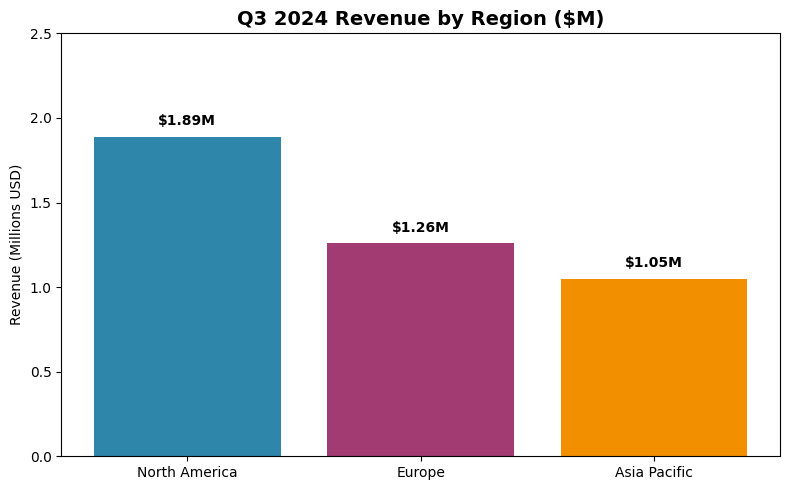

✓ Chart uploaded successfully!
{
  "events": [
    {
      "id": "aev_4d416e35-628d-49e0-a5d9-a60a20ce9fa3",
      "session_key": "ase_artifact_demo_20251216-103059_8d36",
      "type": "artifact_upload",
      "artifacts": [
        {
          "artifact_id": "art_revenue_chart_png_0_5398747691564255_0a43",
          "filename": "revenue_chart.png",
          "mime_type": "image/png",
          "size_bytes": 20605
        }
      ],
      "created_at": "2025-12-16T18:31:20.931Z"
    },
    {
      "id": "aev_1b5ea557-a64c-480f-8ef0-14ba416fa315",
      "session_key": "ase_artifact_demo_20251216-103059_8d36",
      "type": "tool_input",
      "tool_call_id": "call_gadrtSvcUeyCI9Mcw4kn6tJI",
      "tool_configuration_name": "image_read",
      "tool_name": "vectara_image_read",
      "tool_input": {
        "artifact_id": "art_revenue_chart_png_0_5398747691564255_0a43",
        "detail": "auto"
      },
      "created_at": "2025-12-16T18:31:22.515Z"
    },
    {
      "id": "aev_a08f02a

In [13]:
# Create a simple chart image using matplotlib (if available)
if not artifact_agent_key or not session_key:
    print("⚠️  Agent or session not available. Run previous cells first.")
else:
    try:
        import matplotlib.pyplot as plt
        from IPython.display import Image, display
        
        # Create a simple bar chart
        regions = ['North America', 'Europe', 'Asia Pacific']
        revenue = [1.89, 1.26, 1.05]
        
        plt.figure(figsize=(8, 5))
        bars = plt.bar(regions, revenue, color=['#2E86AB', '#A23B72', '#F18F01'])
        plt.title('Q3 2024 Revenue by Region ($M)', fontsize=14, fontweight='bold')
        plt.ylabel('Revenue (Millions USD)')
        plt.ylim(0, 2.5)
        
        # Add value labels on bars
        for bar, val in zip(bars, revenue):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
                     f'${val}M', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        
        # Save the chart
        chart_path = "/tmp/revenue_chart.png"
        plt.savefig(chart_path, dpi=100, bbox_inches='tight')
        plt.close()
        
        print(f"Created chart: {chart_path}")
        
        # Display the image in the notebook
        display(Image(filename=chart_path))
        
        # Upload the image artifact via the events endpoint (without message)
        upload_url = f"{BASE_URL}/agents/{artifact_agent_key}/sessions/{session_key}/events"
        
        with open(chart_path, "rb") as f:
            file_content = f.read()
        
        files = {"files": ("revenue_chart.png", file_content, "image/png")}
        data = {"stream_response": "false"}
        
        upload_response = requests.post(upload_url, headers=upload_headers, files=files, data=data)
        
        if upload_response.status_code in [200, 201]:
            print("✓ Chart uploaded successfully!")
            event_data = upload_response.json()
            print(json.dumps(event_data, indent=2))
        else:
            print(f"Error uploading chart: {upload_response.status_code}")
            print(upload_response.text)
            
    except ImportError:
        print("matplotlib not available. Skipping image example.")
        print("To run this example, install matplotlib: pip install matplotlib")

In [14]:
# Ask the agent to analyze the chart
query = "I've uploaded a revenue chart. Can you describe what you see and provide any insights?"
print(f"User: {query}")
print("\n" + "="*80 + "\n")

response = chat_with_agent(
    artifact_agent_key,
    session_key,
    query,
    show_events=True
)

print(f"Agent Response:\n\n{response}")

User: I've uploaded a revenue chart. Can you describe what you see and provide any insights?



------ Agent Events ------
Event: input_message
Event: agent_output
-------------------------

Agent Response:

The revenue chart for Q3 2024 displays the following information:

- **North America** is the highest contributor, generating $1.89 million.
- **Europe** follows, contributing $1.26 million.
- **Asia Pacific** accounts for $1.05 million.

**Insights:**

1. **Regional Performance:** North America is clearly the leading region, contributing the largest portion of revenue. This indicates a strong market presence and potential for further growth.

2. **Opportunities:** Both Europe and Asia Pacific, while performing well, present opportunities for growth. Targeted strategies could enhance performance in these regions.

3. **Balanced Growth:** The distribution shows a balanced performance across different regions, which can help in mitigating risks associated with market-specific downtur

## Cleanup (Optional)

Delete the agent created in this notebook:

In [15]:
# Delete the artifact agent
if artifact_agent_key:
    response = requests.delete(f"{BASE_URL}/agents/{artifact_agent_key}", headers=headers)
    if response.status_code == 204:
        print(f"Deleted agent: {artifact_agent_key}")
    else:
        print(f"Error deleting agent: {response.text}")

# Clean up temporary files
import os
for temp_file in ["/tmp/q3_sales_report.md", "/tmp/revenue_chart.png"]:
    if os.path.exists(temp_file):
        os.remove(temp_file)
        print(f"Removed: {temp_file}")

Deleted agent: agt_document_analyst_11ef
Removed: /tmp/q3_sales_report.md
Removed: /tmp/revenue_chart.png
